<a href="https://colab.research.google.com/github/AbeTetsuyaR/AbePPO/blob/main/AbePPO1108_without_ohe_MAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import time
import cProfile
import sys
import copy
from torch.distributions.categorical import Categorical
import math
import os
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from tqdm import tqdm  # tqdmをインポート
import matplotlib.pyplot as plt

from scipy.stats import gamma, uniform, truncnorm
#import math

In [3]:
class Environment:
    def __init__(self, n_units=2):
        self.n_units = n_units #number of unit
        #self.n_states = 5 #number of state
        self.inventory = 0
        self.demand = 0
        self.maintenance_status = [0] * self.n_units
        self.interval = 24
        self.remain_interval = 24
        self.MAX_speed = 10/self.interval
        self.MAX_inventory = 0
        self.MAX_demand = 15
        self.MAX_maintenance_time = 0

        self.load_total=1

        self.cp = 40#500
        self.cc = 80#

        self.cps = 0
        self.co = 5
        self.cs =10#500

        self.levels = [0] * self.n_units
        #self.flags = [0] * self.n_units
        self.shape = 3
        self.penalty = 1
        self.L = 25#
        #self.P_Cost =[[100,110,130,160,2540],
                      #[110,120,140,170,2550],
                      #[130,140,160,190,2570],
                      #[160,170,190,220,2600],
                      #[2540,2550,2570,2600,5000]]#convex化

        self.P_Cost =[[0,0,0,0,2500],
                      [0,0,0,0,2500],
                      [0,0,0,0,2500],
                      [0,0,0,0,2500],
                      [2500,2500,2500,2500,5000]]#平滑化
        self.P_Cost_L = 100

        self.Visit =[[0,0,0,0,0],
                      [0,0,0,0,0],
                      [0,0,0,0,0],
                      [0,0,0,0,0],
                      [0,0,0,0,0]]
        self.cntCount=[0,0]

        self.failure_keep1 = 0 #1つ故障しているのに保全を選択しなかった回数
        self.failure_keep2 = 0 #2つ故障しているのに保全を選択しなかった回数
        self.failure_keep3 = 0 #3つ故障しているのに保全を選択しなかった回数
        self.replace_chance = 0 #保全を選択できた回数

    def init_random(self):
        levels = [0,0]
        flags = [0,0]
        self.load_total=1
        return levels, flags, self.load_total



    def reset(self):
        self.levels = np.zeros(self.n_units)

    def complete_maintenance(self, unit_idx):
        self.levels[unit_idx] = 0

    def get_ability(self, level): #良品率
        if level == 0:
            return 1
        elif level == 1:
            return 0.8
        elif level ==2:
            return 0.5
        elif level == 3:
            return 0.1
        return (self.n_states - 1 - level) / (self.n_states - 1)

    def update_demand(self, speed, ability, time):
        if self.demand >= self.inventory:
            self.demand -= self.inventory
            self.inventory = 0.0
        else:
            self.inventory -= self.demand
            self.demand = 0.0
        return max(0, self.demand-self.inventory-ability*speed*time)

    def update_inventory(self, speed, ability, time):
        if self.demand <= self.inventory + ability * speed * time:
            return min(self.MAX_inventory, -self.demand+self.inventory+ability*speed*time), max(0, -self.MAX_inventory-self.demand+self.inventory+ability*speed*time)
        else:
            return 0.0, 0.0

    def get_maintenance_time(self,level):
        return 0

    def update_maintenance_time(self, unit_idx):
        return 0

    def one_hot_encode(self):
        level_ohe = []
        #mstatus_ohe = []
        for unit_idx in range(self.n_units):
            l = [0] * self.n_states
            #m = [0] * (self.MAX_maintenance_time + 1)
            l[min(math.floor(self.levels[unit_idx]),self.n_states-1)] = 1
            #m[self.maintenance_status[unit_idx]] = 1
            level_ohe = level_ohe + l
            #mstatus_ohe = mstatus_ohe + m
        return level_ohe #mstatus_oheは削除



    def operation(self, replacements, load_rate):
        #print(self.levels,"levels_before")
        reward = 0
        #print(load_rate)

        flag = 0

        #保全の意思決定
        #print(replacements)

        if replacements==[1,1]: #稼働継続

          #reward -= self.P_Cost[min(math.floor(self.levels[0]),self.n_states-1)][min(math.floor(self.levels[1]),self.n_states-1)] #rewardを最初に計算
          if self.levels[0]>self.L:
            reward -= self.P_Cost_L
          #else:
            #reward -= 40*(3**(0.01*(self.levels[0])))
          if self.levels[1]>self.L:
            reward -= self.P_Cost_L
          #else:
            #reward -= 40*(3**(0.01*(self.levels[1])))
          #print(reward)
          # パラメータの設定
          scales=[0,0]
          shape0 = 0.69  # ガンマ分布のパラメータ v1 用 0.69 100倍にしてみる
          shape1 = 0.69   # ガンマ分布のパラメータ v2 用
          tau = 0.5  # ケンドールの順位相関係数

          theta = 1 / (1 - tau)

          #if load_rate<0:##
            #load_rate=0
          #if load_rate>1:
            #load_rate=1
          loads=[0,0]
          loads[0]=self.load_total*load_rate
          loads[1]=self.load_total*(1-load_rate)

          #print(speeds, "speeds")
          #尺度パラメータ計算
          for i in range(self.n_units):
            scales[i]=6.491*(loads[i]**2)+0.726
            #scales[i]=6.491*(speeds[i]**0.5)+0.726
            scales[i]=scales[i] #1/10000倍にしてみる


          # 一様分布から独立にサンプリング
          u = uniform.rvs(size=1)
          v = uniform.rvs(size=1)
          #print("u,v:",u,v)
          # ガンベルコピュラの逆関数を適用
          x = (-np.log(u.item())) ** theta#arrayをfloatに
          y = (-np.log(v.item())) ** theta
          #print("x,y:",x,y)

          t = (x + y) ** (1/theta)
          #print("t:",t)

          u_new = np.exp(-t * (x / (x + y)))
          v_new = np.exp(-t * (y / (x + y)))

          # ガンマ分布に変換
          v1 = gamma.ppf(u_new, shape0, scale=scales[0])
          v2 = gamma.ppf(v_new, shape1, scale=scales[1])
          #print(v1,v2)
          #v1 = gamma.rvs(shape0, scale=scales[0])
          #v2 = gamma.rvs(shape1, scale=scales[1])

          #print("稼働継続")
          #print(v1,v2, "劣化増分")
          self.levels[0]+=v1
          self.levels[1]+=v2
          #print(self.levels, "劣化")



        elif replacements==[0,1]: #1個取替(順張り) #0907
          reward -= self.cs

          if self.levels[0]>self.levels[1]:
            unit_replaced=0
          else:
            unit_replaced=1

          if self.levels[unit_replaced]<self.L:
            reward -= self.cp
          else:
            reward -= self.cc
          self.levels[unit_replaced]=0

        elif replacements==[1,0]:#1個取替(逆張り)
          reward -= self.cs

          if self.levels[0]>self.levels[1]:
            unit_replaced=1
          else:
            unit_replaced=0

          if self.levels[unit_replaced]<self.L:
            reward -= self.cp
          else:
            reward -= self.cc
          self.levels[unit_replaced]=0

        else: #両方取替
          reward -= self.cs
          if self.levels[0]<self.L:
            reward -= self.cp
          else:
            reward -= self.cc
          if self.levels[1]<self.L:
            reward -= self.cp
          else:
            reward -= self.cc
          self.levels=[0,0]

        #print(self.levels)
        #print(reward)

        #level_ohe= self.one_hot_encode()

        #print(f'状態:{self.levels}, 保全状態:{self.maintenance_status}, 在庫:{self.inventory}, 需要:{self.demand}, 残り時間:{self.remain_interval}, 保全行動:{replacements}, {speeds}')
        #print("#############")

        flags = [0,0]#故障フラグ
        if self.levels[0] >= self.L:
          flags[0] = 1
        if self.levels[1] >= self.L:
          flags[1] = 1

        #切断正規分布
        #dist_N = truncnorm(0, 2, loc=1, scale=1)
        #self.load_total=float(dist_N.rvs(1))
        #self.load_total = float(np.random.randint(0, 2))+1#0916
        #print(self.load_total)

        #self.Visit[min(math.floor(self.levels[0]),self.n_states-1)][min(math.floor(self.levels[1]),self.n_states-1)] += 1
        #levels_after=[]
        #for i in range(self.n_units):
          #l=list([self.levels[i][0]])
          #levels_after =levels_after+l
        #print(self.levels,"levels_after")

        return reward, self.levels, flags, self.load_total

        #return reward, level_ohe, mstatus_ohe, \
        #       0, (self.demand-mean)/variance, self.remain_interval * 2 / self.interval - 1, flag


    #劣化レベル順にすべき可能性

In [4]:
class PPOMemory:
    def __init__(self,batch_size, interval, beta, GAE_lam):
        self.states = []
        self.probs_dsc = []
        self.probs_cnt = []
        self.vals = []
        self.acts_dsc = []
        self.acts_cnt = []
        self.rewards = []
        self.time = []
        self.batch_size = batch_size
        self.interval = interval
        self.beta = beta
        self.advantage = []
        self.lam = GAE_lam



    def generate_advantage(self):
        advantage = []
        adv = 0
        #gamma = math.exp(-self.beta)
        #lambd = 0.0
        beta=0.99
        for t in reversed(range(len(self.rewards))):
            if t == len(self.rewards) - 1:
                adv = self.rewards[t] - self.vals[t]
            else:
                adv = self.rewards[t] + beta * self.vals[t+1] - self.vals[t]
            #gae = delta + lambd * gamma * gae  # Assuming lambda = 1 for simplicity, otherwise use gamma * lambda * gae
            advantage.insert(0, adv)
        self.advantage = np.array(advantage, dtype=np.float32)


    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
               np.array(self.acts_dsc),\
               np.array(self.acts_cnt),\
               np.array(self.probs_dsc),\
               np.array(self.probs_cnt),\
               np.array(self.vals),\
               np.array(self.rewards),\
               np.array(self.advantage),\
               batches



    def store_memory(self, state, act_dsc, act_cnt, probs_dsc, probs_cnt, vals, reward):
        self.states.append(state)
        self.acts_dsc.append(act_dsc)
        self.acts_cnt.append(act_cnt)
        #self.probs.append(probs)
        self.probs_dsc.append(probs_dsc)
        self.probs_cnt.append(probs_cnt)
        self.vals.append(vals)
        self.rewards.append(reward)
        #self.time.append(time)

    def clear_memory(self):
        self.states = []
        self.probs_dsc = []
        self.probs_cnt = []
        self.acts_dsc = []
        self.acts_cnt = []
        self.rewards = []
        self.vals = []
        self.time = []

"""
    def generate_advantage(self):
        advantage = []
        gae = 0
        gamma = math.exp(-self.beta)
        lambd = 0.0
        for t in reversed(range(len(self.rewards))):
            if t == len(self.rewards) - 1:
                delta = self.rewards[t] - self.vals[t]
            else:
                delta = self.rewards[t] + gamma * self.vals[t+1] - self.vals[t]
            gae = delta + lambd * gamma * gae  # Assuming lambda = 1 for simplicity, otherwise use gamma * lambda * gae
            advantage.insert(0, gae)
        self.advantage = np.array(advantage, dtype=np.float32)

    def generate_advantage(self):

        advantage = []
        gae = 0
        for t in reversed(range(len(self.rewards))):
            gamma = 1
            if t == len(self.rewards) - 1:
                delta = self.rewards[t] - self.vals[t]
            else:
                gamma = math.exp(-self.beta*1) #修正
                delta = self.rewards[t] + gamma * self.vals[t+1] - self.vals[t]
            gae = delta + gamma * gamma * gae
            advantage.insert(0, gae)
        self.advantage = np.array(advantage,dtype=np.float32)
"""

'\n    def generate_advantage(self):\n        advantage = []\n        gae = 0\n        gamma = math.exp(-self.beta)\n        lambd = 0.0\n        for t in reversed(range(len(self.rewards))):\n            if t == len(self.rewards) - 1:\n                delta = self.rewards[t] - self.vals[t]\n            else:\n                delta = self.rewards[t] + gamma * self.vals[t+1] - self.vals[t]\n            gae = delta + lambd * gamma * gae  # Assuming lambda = 1 for simplicity, otherwise use gamma * lambda * gae\n            advantage.insert(0, gae)\n        self.advantage = np.array(advantage, dtype=np.float32)\n\n    def generate_advantage(self):\n\n        advantage = []\n        gae = 0\n        for t in reversed(range(len(self.rewards))):\n            gamma = 1\n            if t == len(self.rewards) - 1:\n                delta = self.rewards[t] - self.vals[t]\n            else:\n                gamma = math.exp(-self.beta*1) #修正\n                delta = self.rewards[t] + gamma * self.va

In [5]:
class MATEncoderDecoderNetwork(nn.Module):
    def __init__(self, state_dim, d_model, n_heads, d_ff, n_layers, action_dim_a, action_dim_b, lr, chkpt_dir=""):
        super(MATEncoderDecoderNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, "EncoderDecoder_torch_mat")

        # Input embedding layer to match d_model
        self.input_embedding = nn.Linear(state_dim, d_model)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=d_ff, batch_first=True)#エンコーダ(1層)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)#エンコーダ(n層)

        # Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=d_ff, batch_first=True)#デコーダ(1層)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=n_layers)#デコーダ(n層)

        # Linear layers for action outputs
        self.action_a_head = nn.Linear(d_model, action_dim_a)  # For discrete actions of Agent A
        self.action_b_mean = nn.Linear(d_model, action_dim_b)  # Mean for continuous actions of Agent B
        self.action_b_log_std = nn.Linear(d_model, action_dim_b)  # Log std for continuous actions of Agent B

        # Value estimation head
        self.value_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 1)  # Output scalar value V(s)
        )

        # Optimizer with different learning rates for each module
        self.optimizer = optim.Adam([
            {'params': self.input_embedding.parameters(), 'lr': lr*10},  # Input embedding
            {'params': self.encoder.parameters(), 'lr': lr*10},               # Transformer Encoder
            {'params': self.decoder.parameters(), 'lr': lr*10},         # Transformer Decoder
            {'params': self.action_a_head.parameters(), 'lr': lr},   # Action head for Agent A
            {'params': self.action_b_mean.parameters(), 'lr': lr},         # Mean for Agent B's actions
            {'params': self.action_b_log_std.parameters(), 'lr': lr},      # Log std for Agent B's actions
            {'params': self.value_head.parameters(), 'lr': lr*10000}       # Value estimation head
        ])


        # 以下に初期化コードを追加
        self.init_dsc_weights()

        # Activation functions
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def init_dsc_weights(self):
        # ここで特定の出力確率を設定するための重みとバイアスを設定
        with torch.no_grad():
            # すべての出力がほぼ等しくなるように設定
            self.action_a_head.weight.fill_(0.0)
            # 特定の確率分布に調整
            self.action_a_head.bias.data = torch.log(torch.tensor([0.2, 0.2, 0, 0.6]))  # logを取るのがポイント

    def init_mean_weights(self):
        # mean レイヤーの初期化
        with torch.no_grad():
            self.action_b_mean.weight.fill_(0.0)
            self.action_b_mean.bias.fill_(0.0)  # ここで固定出力0.5を設定#0に変更

    def init_std_weights(self):
        # std レイヤーの初期化
        with torch.no_grad():
            self.value_head.weight.fill_(0.0)
            self.value_head.bias.fill_(0.0)  # ここで固定出力0.7を設定

    def forward(self, state):
        state_rev = state.clone()#0907
        #print("state;",state)
        if state[0][0]>state[0][1]:
          state_rev[:, [0, 1]] = state_rev[:, [1, 0]]
          state_rev[:, [2, 3]] = state_rev[:, [3, 2]] #flag
        #print("state;",state_rev)
        """
        Forward pass:
        Args:
            state (torch.Tensor): Input state tensor with shape (batch_size, seq_len, state_dim).

        Returns:
            dist_a (Categorical): Distribution over discrete actions for Agent A.
            dist_b (Normal): Distribution over continuous actions for Agent B.
            value (torch.Tensor): Estimated value V(s).
        """
        # Add sequence dimension if missing
        if state_rev.ndim == 2:
            state_rev = state_rev.unsqueeze(1)

        # Embed the input to match d_model
        state_rev = self.input_embedding(state_rev)

        # Encoder pass
        encoded_state = self.encoder(state_rev)

        # Prepare decoder input (use encoded state as both input and context)
        decoder_input = encoded_state.clone()
        decoder_output = self.decoder(tgt=decoder_input, memory=encoded_state)

        # Agent A (Discrete action)
        action_a_logits = self.action_a_head(decoder_output[:, 0, :])  # Take first token output
        action_a_probs = self.softmax(action_a_logits)
        dist_a = Categorical(action_a_probs)

        # Agent B (Continuous action)
        action_b_mean = self.tanh(self.action_b_mean(decoder_output[:, 0, :]))
        action_b_log_std = torch.clamp(self.action_b_log_std(decoder_output[:, 0, :]), min=-20, max=2)
        action_b_std = action_b_log_std.exp()
        if state[0][0]<state[0][1]:
          dist_b = torch.distributions.Normal(loc=action_b_mean, scale=action_b_std)
        else:
          dist_b = torch.distributions.Normal(loc=-action_b_mean, scale=action_b_std)


        # Value estimation
        #value = self.value_head(encoded_state[:, 0, :])  # Use the first token's representation
        value = self.value_head(encoded_state)

        return dist_a, dist_b, value

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))


In [6]:
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=32, fc2_dims=32, fc3_dims=64, chkpt_dir=""):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, "critic_torch_ppo")
        self.critic = nn.Sequential(
            nn.Linear(input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims,fc2_dims),
            nn.ReLU(),
            #nn.Linear(fc2_dims,fc3_dims),
            #nn.ReLU(),
            nn.Linear(fc2_dims,1)
        )
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 重みの初期化
        #self.init_weights()

        self.to(self.device)

        self.scheduler_critic = optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.95)



    def init_weights(self):
        #with torch.no_grad():
            #self.mean.weight.fill_(0.0)
            #self.mean.bias.fill_(0.0)  # ここで固定出力0.5を設定#0に変更

        for layer in self.critic:
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)
                layer.bias.data.fill_(0.0)  # バイアスを0で初期化



    def forward(self, state):
        state_rev = state.clone()#0907
        if state[0][0]>state[0][1]:
          state_rev[:, [0, 1]] = state_rev[:, [1, 0]]
          state_rev[:, [2, 3]] = state_rev[:, [3, 2]]#flag
        value = self.critic(state_rev)#0908

        return value

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))

In [7]:
test_batch = 0
class Agent:
    def __init__(self, n_units, n_states, MAX_maintenance_time, input_dims, beta=0.0005, GAE_lam=0.00, interval=24,
                 alpha=0.03, alpha_critic=0.01,
                 policy_clip=0.2, batch_size=512*4, n_epochs=4):
        self.beta = beta
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs

        self.loss_history = []
        self.loss_history_detail = []

        self.actor_loss_history = []
        self.actor_loss_history_detail = []
        self.critic_loss_history = []
        self.critic_loss_history_detail = []
        self.entropy_history = []
        self.kl_divergence_history = []

        #self.actor_d = ActorNetwork(n_units, n_states, MAX_maintenance_time, input_dims, alpha_actor_d, Actor_Num=1)
        #self.actor_c = ActorNetwork(n_units, n_states, MAX_maintenance_time, input_dims, alpha_actor_c, Actor_Num=2)
        #self.critic = CriticNetwork(input_dims, alpha_critic)
        self.encoder_decoder = MATEncoderDecoderNetwork(state_dim=input_dims, d_model=128, n_heads=4, d_ff=512, n_layers=6, action_dim_a=4, action_dim_b=1, lr=alpha)
        self.memory = PPOMemory(batch_size, interval=interval, beta=beta, GAE_lam=GAE_lam)

    def remember(self,state,action_dsc,action_cnt,probs_dsc, probs_cnt,vals,reward):#probs_dsc,probs_cnt
        self.memory.store_memory(state,action_dsc,action_cnt,probs_dsc, probs_cnt,vals,reward)

    def save_models(self):
        print("... saving models ...")
        #self.actor_d.save_checkpoint(1)
        #self.actor_c.save_checkpoint(2)
        #self.critic.save_checkpoint()
        self.encoder_decoder.save_checkpoint()

    def load_models(self):
        print("... loading models ...")
        #self.actor_d.load_checkpoint(1)
        #self.actor_c.load_checkpoint(2)
        #self.critic.load_checkpoint()
        self.encoder_decoder.load_checkpoint()

    def choose_action(self,observation):
        #state1 = torch.tensor(np.array([observation]),dtype=torch.float).to(self.actor_d.device)
        state1 = torch.tensor(np.array([observation]),dtype=torch.float).to(self.encoder_decoder.device)
        #dist_dsc = self.actor_d(state1,1)
        #state2 = torch.tensor(np.array([observation]),dtype=torch.float).to(self.actor_c.device)
        #dist_cnt = self.actor_c(state1,2)

        #state_rev = state.clone()
        #state_rev[:, [0, 1]] = state_rev[:, [1, 0]]
        #value = (self.critic(state)+self.critic(state_rev))/2
        #value = self.critic(state1)#1007本当？
        dist_dsc, dist_cnt, value = self.encoder_decoder(state1)

        act_dsc = dist_dsc.sample()

        act_cnt = dist_cnt.sample()

        log_prob_dsc = torch.squeeze(dist_dsc.log_prob(act_dsc)).item()

        if act_dsc.item() == 3:
          log_prob_cnt = torch.squeeze(dist_cnt.log_prob(act_cnt)).item()
          #print(log_prob_cnt, "log_prob_cnt")
        else:
          #log_prob_cnt = 0 #dist_cntを参照しないことの補正
          log_prob_cnt = torch.squeeze(dist_cnt.log_prob(act_cnt)).item()


        log_prob = log_prob_dsc + log_prob_cnt

        value = torch.squeeze(value).item()

        return act_dsc, act_cnt, log_prob_dsc, log_prob_cnt, value

    def choose_action_max_prob(self,observation):
        #state1 = torch.tensor(np.array([observation]),dtype=torch.float).to(self.actor_d.device)
        state1 = torch.tensor(np.array([observation]),dtype=torch.float).to(self.encoder_decoder.device)
        #dist_dsc = self.actor_d(state1,1)
        #state2 = torch.tensor(np.array([observation]),dtype=torch.float).to(self.actor_c.device)
        #dist_cnt = self.actor_c(state1,2)
        #print("state:", state, "dist_dsc.probs:", dist_dsc.probs, "dist_cnt.mean:",dist_cnt.mean,"dist_cnt.scale", dist_cnt.scale)
        dist_dsc, dist_cnt, value = self.encoder_decoder(state1)

        act_dsc = torch.argmax(dist_dsc.probs)
        act_cnt = dist_cnt.mean
        #print(act_dsc, ":act_dsc")
        #print(act_cnt, ":act_cnt")

        #value = self.critic(state1)


        log_prob_dsc = torch.squeeze(dist_dsc.log_prob(act_dsc)).item()
        log_prob_cnt = torch.squeeze(dist_cnt.log_prob(act_cnt)).item()
        log_prob = log_prob_dsc + log_prob_cnt

        value = torch.squeeze(value).item()

        return act_dsc, act_cnt, log_prob_dsc, log_prob_cnt, value

    def learn(self,episode, entropy_weight):
        self.memory.generate_advantage()
        actor_loss_sum = 0
        critic_loss_sum = 0
        entropy_sum = 0
        kl_divergence_sum = 0

        for _ in range(self.n_epochs):
        #for _ in tqdm(range(self.n_epochs), desc="Training Progress"):  # tqdmを用いて進捗表示
            """
            rewards = self.memory.rewards
            values = self.memory.vals
            times = self.memory.time
            advantage = np.zeros(len(reward_arr),dtype=np.float32)
            for t in range(len(reward_arr)-1):
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += math.exp(-self.beta * times[k]) * \
                        (reward_arr[k]+math.exp(-self.beta * (-times[k]%self.interval+self.interval))*values[k+1]-values[k])
                advantage[t] = a_t
            advantage = torch.tensor(advantage).to(self.actor.device)
            """
            state_arr, act_dsc_arr, act_cnt_arr, old_probs_dsc_arr, old_probs_cnt_arr, vals_arr, reward_arr, advantage, batches=self.memory.generate_batches()
            values = vals_arr
            """
            values = vals_arr
            times = time_arr
            advantage = np.zeros(len(reward_arr),dtype=np.float32)
            for t in range(len(reward_arr)-1):
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += math.exp(-self.beta * times[k]) * (reward_arr[k]+self.gamma*values[k+1]-values[k])
                advantage[t] = a_t
            """
            advantage = torch.tensor(advantage).to(self.encoder_decoder.device)


            values = torch.tensor(values).to(self.encoder_decoder.device)
            start = time.time()
            for batch in batches:  # 各バッチの進捗を表示
                advantage_batch = advantage[batch].clone()
                states1 = torch.tensor(state_arr[batch], dtype=torch.float).to(self.encoder_decoder.device)
                #states2 = torch.tensor(state_arr[batch], dtype=torch.float).to(self.actor_c.device)

                # Forward pass
                dist_dsc, dist_cnt, value = self.encoder_decoder(states1)

                #離散エージェント
                log_old_probs_dsc = torch.tensor(old_probs_dsc_arr[batch]).to(self.encoder_decoder.device)
                acts_dsc = torch.tensor(act_dsc_arr[batch]).to(self.encoder_decoder.device)
                #dist_dsc = self.encoder_decoder(states1)
                log_new_probs_dsc = dist_dsc.log_prob(acts_dsc) #pi_new
                prob_ratio_dsc = log_new_probs_dsc.exp()/log_old_probs_dsc.exp()

                entropy_dsc = dist_dsc.entropy().sum(dim=0).mean()

                weighted_probs_dsc = advantage_batch*prob_ratio_dsc
                weighted_clipped_probs_dsc = torch.clamp(prob_ratio_dsc, 1-self.policy_clip, 1+self.policy_clip)*advantage_batch
                actor_loss_dsc = -torch.min(weighted_probs_dsc, weighted_clipped_probs_dsc).mean()

                total_loss_dsc = actor_loss_dsc #+ 0.01 * entoropy_dsc

                #self.actor_d.optimizer_discrete.zero_grad()
                #total_loss_dsc.backward(retain_graph=True)
                #self.actor_d.optimizer_discrete.step()

                #with torch.no_grad():
                    #advantage_batch = advantage_batch*prob_ratio_dsc.to(advantage_batch.dtype)

                #連続エージェント
                log_old_probs_cnt = torch.tensor(old_probs_cnt_arr[batch]).to(self.encoder_decoder.device)
                acts_cnt = torch.tensor(act_cnt_arr[batch]).to(self.encoder_decoder.device)
                #dist_cnt = self.actor_c(states1,2)
                log_new_probs_cnt = dist_cnt.log_prob(acts_cnt)
                prob_ratio_cnt = log_new_probs_cnt.exp()/log_old_probs_cnt.exp()
                #log_new_probs = dist_dsc.log_prob(acts_dsc) + dist_cnt.log_prob(acts_cnt)

                entropy_cnt = dist_cnt.entropy().sum(dim=0).mean()

                weighted_probs_cnt = advantage_batch*prob_ratio_cnt
                weighted_clipped_probs_cnt = torch.clamp(prob_ratio_cnt, 1-self.policy_clip, 1+self.policy_clip)*advantage_batch
                actor_loss_cnt = -torch.min(weighted_probs_cnt, weighted_clipped_probs_cnt).mean()

                total_loss_cnt = actor_loss_cnt #+ 0.01 * entoropy_cnt

                #self.actor_c.optimizer_continuous.zero_grad()
                #total_loss_cnt.backward(retain_graph=True)
                #self.actor_c.optimizer_continuous.step()



                #critic_value = self.critic(states1)#0907
                critic_value = torch.squeeze(value)

                returns = advantage[batch] + values[batch]
                critic_loss = F.mse_loss(returns.float(),critic_value.float())



                #prob_ratio = log_new_probs.exp()/log_old_probs.exp()
                #weighted_probs = advantage[batch]*prob_ratio
                #weighted_clipped_probs = torch.clamp(prob_ratio, 1-self.policy_clip, 1+self.policy_clip)*advantage[batch]
                #actor_loss = -torch.min(weighted_probs, weighted_clipped_probs).mean()
                #print("log_old_probs_cnt.exp():",log_old_probs_cnt.exp())
                #print("log_new_probs_cnt.exp():",log_new_probs_cnt.exp())
                #print("log_old_probs_cnt:",log_old_probs_cnt)
                #print("log_new_probs_cnt",log_new_probs_cnt)

                #print("prob_ratio_dsc:",prob_ratio_dsc)
                #print("prob_ratio_cnt:",prob_ratio_cnt)


                #weighted_probs_dsc = advantage[batch]*prob_ratio_dsc
                #weighted_clipped_probs_dsc = torch.clamp(prob_ratio_dsc, 1-self.policy_clip, 1+self.policy_clip)*advantage[batch]
                #actor_loss_dsc = -torch.min(weighted_probs_dsc, weighted_clipped_probs_dsc).mean()

                #weighted_probs_cnt = advantage[batch]*prob_ratio_cnt
                #weighted_clipped_probs_cnt = torch.clamp(prob_ratio_cnt, 1-self.policy_clip, 1+self.policy_clip)*advantage[batch]
                #actor_loss_cnt = -torch.min(weighted_probs_cnt, weighted_clipped_probs_cnt).mean()


                #critic_loss = critic_loss.float()
                #print(actor_loss)
                #print(critic_loss)
                #print("#####")


                #entropy = torch.clamp(entropy_dsc,min=0) + torch.clamp(entropy_cnt,min=0)
                #entropy = torch.clamp(dist_dsc.entropy().mean(),min=0) + torch.clamp(dist_cnt.entropy().mean(), min=0.0)

                total_loss = total_loss_dsc + total_loss_cnt + 0.5*critic_loss #+ 0.01*entropy
                #total_loss = actor_loss + 0.5*critic_loss + entropy_weight*entropy

                #if episode >= threshold:
                  #print("FLAG")


                #if episode >= threshold:
                  #print("FLAG")


                #self.actor.optimizer.zero_grad()
                #actor_loss.backward()
                #self.actor.optimizer.step()

                #self.critic.optimizer.zero_grad()
                #critic_loss.backward()
                #self.critic.optimizer.step()

                #self.loss_history_detail.append(total_loss.item())

                # Backpropagation
                self.encoder_decoder.optimizer.zero_grad()
                total_loss.backward()
                self.encoder_decoder.optimizer.step()

                # Logging
                #actor_loss_sum += actor_loss_dsc.item()+actor_loss_cnt.item()
                actor_loss_sum += actor_loss_dsc.item()+actor_loss_cnt.item()
                critic_loss_sum += critic_loss.item()
                entropy_sum += entropy_dsc.item()+entropy_cnt.item()
                kl_divergence_sum += torch.distributions.kl_divergence(Categorical(logits=log_old_probs_dsc+log_old_probs_cnt), Categorical(logits=log_new_probs_dsc+log_new_probs_cnt)).mean().item()

                #print("advantage[batch].size(),advantage[batch]:",advantage[batch].size(),advantage[batch])

        print(f'actor loss: {actor_loss_sum}, critic loss: {critic_loss_sum}, entropy: {entropy_sum}, KL divergence: {kl_divergence_sum}')
        self.loss_history.append(np.mean(self.loss_history_detail[-self.n_epochs:]))
        self.actor_loss_history.append(actor_loss_sum)
        self.critic_loss_history.append(critic_loss_sum)
        self.entropy_history.append(entropy_sum)
        self.kl_divergence_history.append(kl_divergence_sum)
            # Update sums
        #self.actor.scheduler_actor.step()  # 学習率を更新
        #self.critic.scheduler_critic.step()  # 学習率を更新
        self.memory.clear_memory()

In [8]:
os.getcwd()

'/content'

In [9]:
#エージェントの初期化
n_units = 2
n_states = 5
MAX_maintenance_time = 0
#input_size = n_units * n_states + n_units * (MAX_maintenance_time) + 2 #MDPのため[残り時間]と[保全意思決定時]の2つの入力は入れない
input_size = n_units*2 + 1 #flagを追加#lを追加
#action_size = 2**n_units  # 行動数は2^2個
batch_size = 512*4#512-5120
interval = 24
#alpha_actor_d = 0.0001#ここを変更する0.0001#0917
alpha = 0.00001
alpha_critic = 0.2#ここを変更する0.1
n_epochs = 4
policy_clip = 0.1
beta=0.0005


agent = Agent(n_units=n_units,
              input_dims=input_size,
              n_states=n_states,
              MAX_maintenance_time=MAX_maintenance_time,
              beta=beta,
              interval=interval,
              alpha=alpha,
              #alpha_actor_c=alpha_actor_c,
              alpha_critic=alpha_critic,
              policy_clip=policy_clip,
              batch_size=batch_size,
              n_epochs=n_epochs)
env = Environment()

In [10]:
observation0=[0,0,0,0,1]
state0 = torch.tensor(np.array([observation0]),dtype=torch.float).to(agent.encoder_decoder.device)
dist_dsc0,dist_cnt0,value0 = agent.encoder_decoder(state0)
#state2 = torch.tensor(np.array([observation0]),dtype=torch.float).to(agent.actor_c.device)
#dist_cnt0 = agent.encoder_decoder(state0)
#value0 = agent.critic(state0)#1007本当？
print("state:", state0, "dist_dsc.probs:", dist_dsc0.probs, "dist_cnt.mean:",dist_cnt0.mean,"dist_cnt.scale", dist_cnt0.scale,"value0:",value0)

state: tensor([[0., 0., 0., 0., 1.]]) dist_dsc.probs: tensor([[0.2000, 0.2000, 0.0000, 0.6000]], grad_fn=<DivBackward0>) dist_cnt.mean: tensor([[-0.5989]], grad_fn=<NegBackward0>) dist_cnt.scale tensor([[0.5995]], grad_fn=<ExpBackward0>) value0: tensor([[[-0.1584]]], grad_fn=<ViewBackward0>)


In [12]:
num_episode=128#4で1分
threshold = 0 #cnt学習を開始するエピソード
best_reward = -np.inf
episode_reward_history = []
avg_cost = 0
critic_value0_history=[]
entropy_weight=0.01

for episode in range(num_episode):
    episode_reward = 0
    operation_time = 0
    one_action = 0
    two_action = 0
    three_action = 0
    penalty_action = 0
    #level_ohe, load_total = env.init_random()
    levels, flags, load_total = env.init_random()
    if episode % 100 == 0:
        interval_time_episode = time.time()
    interval_time_episode = time.time()
    for i in range(256):#1024*8
        #state = level_ohe + list([inventory,demand])
        #print(levels,"levels")
        state = levels + flags + list([load_total])
        #print(state)
        act_dsc, act_cnt, log_prob_dsc, log_prob_cnt, val = agent.choose_action(state)
        log_prob=log_prob_dsc+log_prob_cnt
        act_dsc_list = [int(bit) for bit in format(act_dsc.item(), f'0{env.n_units}b')]
        if sum(act_dsc_list) == 2:
            one_action += 1
        elif sum(act_dsc_list) == 1:
            two_action += 1
        elif sum(act_dsc_list) == 0:
            three_action += 1
        act_cnt_np = act_cnt.squeeze().cpu().numpy().copy()
        act_cnt_np = act_cnt_np * 0.5 + 0.5 #補正

        if act_cnt_np<0.5:
          env.cntCount[0]+=1
        else:
          env.cntCount[1]+=1
        #print(act_dsc_list,act_cnt_np)
        #reward, level_ohe_next, load_total_next= env.operation(act_dsc_list,act_cnt_np)
        reward, levels_next, flags_next, load_total_next= env.operation(act_dsc_list,act_cnt_np)

        episode_reward = episode_reward *0.99 + reward
        #episode_reward = episode_reward + reward *0.99
        #penalty_action += flag
        #if remain_interval > remain_interval_next:
            #operation_time += (remain_interval+1)/2*interval - (remain_interval_next+1)/2*interval
        #else:
            #operation_time += (remain_interval_next + 1) / 2 * interval
        agent.remember(state, act_dsc.item(), act_cnt.squeeze().cpu().numpy().copy(), log_prob_dsc, log_prob_cnt, val, reward)
        #agent.remember(state, act_dsc.item(), act_cnt.squeeze().cpu().numpy().copy(), log_prob, val, reward)
        levels = levels_next
        flags = flags_next
        #mstatus_ohe = mstatus_ohe_next
        #inventory = inventory_next
        #demand = demand_next
        #remain_interval = remain_interval_next
        load_total = load_total_next
        if (i + 1) % 128 == 0:
           print("episode_reward,reward:",episode_reward,reward,"act_dsc, act_cnt:",act_dsc_list,act_cnt_np,"log_prob_dsc, log_prob_cnt, levels:",log_prob_dsc, log_prob_cnt, levels)
    #print(f'{episode}エピソード目の時間：{time.time()-interval_time_episode}')
    interval_time_episode = time.time()
    if threshold<=episode:
      entropy_weight =0.01


    agent.learn(episode, entropy_weight)

    old_agent = Agent(n_units=n_units,
                        input_dims=input_size,
                        n_states=n_states,
                        MAX_maintenance_time=MAX_maintenance_time,
                        beta=beta,
                        interval=interval,
                        alpha=alpha,
                        #alpha_actor_c=alpha_actor_c,
                        alpha_critic=alpha_critic,
                        policy_clip=policy_clip,
                        batch_size=batch_size,
                        n_epochs=n_epochs)
    if episode != 0:
        old_agent.load_models()

    #if Check_convergence(agent, old_agent, n_units, n_states, MAX_maintenance_time):
    #    break



    agent.save_models()
    print(f'状態{state}, 離散行動：{act_dsc_list}, 連続行動：{act_cnt_np}')
    print(f'[保全を選択できた回数,1個故障で保全を選ばない回数, 2個故障で保全を選ばない回数, 3個故障で保全を選ばない回数] = [{env.replace_chance}, {env.failure_keep1}, {env.failure_keep2}, {env.failure_keep3}]')
    env.replace_chance = 0
    env.failure_keep1 = 0
    env.failure_keep2 = 0
    env.failure_keep3 = 0
    #print(f'{episode}エピソード目の学習時間：{time.time()-interval_time_episode}')
    episode_reward_history.append(episode_reward)
    print(f'{episode}エピソード目の累積報酬：{episode_reward}, 一つ保全の回数：{one_action}, 二つ保全の回数：{two_action}, 三つ保全の回数：{three_action}, 違反回数：{penalty_action},episode_reward_history：{episode_reward_history}')

    #_, _, value = agent.encoder_decoder(state0.unsqueeze(0))  # バッチ次元を追加
    #value0 = float(value[0, 0])  # 推定価値を取得
    #critic_value0_history.append(float(value[0, 0]))



episode_reward,reward: -3729.0467316485624 0 act_dsc, act_cnt: [1, 1] -0.6489342451095581 log_prob_dsc, log_prob_cnt, levels: -0.5108255743980408 -2.0925889015197754 [0.23332462544681704, 78.63694712444469]
episode_reward,reward: -5050.9437971793195 0 act_dsc, act_cnt: [1, 1] 0.7512129247188568 log_prob_dsc, log_prob_cnt, levels: -0.5108255743980408 -1.8882145881652832 [24.039119552370053, 9.441582420607308]
actor loss: 501.39426133990435, critic loss: 21320.560546875, entropy: 2669.670928955078, KL divergence: inf
... saving models ...
状態[21.30152044402615, 8.523607765092786, 0, 0, 1], 離散行動：[1, 1], 連続行動：0.7512129247188568
[保全を選択できた回数,1個故障で保全を選ばない回数, 2個故障で保全を選ばない回数, 3個故障で保全を選ばない回数] = [0, 0, 0, 0]
0エピソード目の累積報酬：-5050.9437971793195, 一つ保全の回数：171, 二つ保全の回数：44, 三つ保全の回数：41, 違反回数：0,episode_reward_history：[-5050.9437971793195]


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


episode_reward,reward: -3610.1577508633673 0 act_dsc, act_cnt: [1, 1] -1.2498385906219482 log_prob_dsc, log_prob_cnt, levels: -0.5097129940986633 -3.3370161056518555 [10.1861830167202, 17.03265155028884]
episode_reward,reward: -5558.387110778186 -90 act_dsc, act_cnt: [0, 0] 0.3401322662830353 log_prob_dsc, log_prob_cnt, levels: -1.6120935678482056 -1.1143420934677124 [0, 0]
actor loss: 506.383198404337, critic loss: 27557.4072265625, entropy: 2352.4610443115234, KL divergence: inf
... loading models ...
... saving models ...
状態[4.615696901335716, 17.372220111598246, 0, 0, 1], 離散行動：[0, 0], 連続行動：0.3401322662830353
[保全を選択できた回数,1個故障で保全を選ばない回数, 2個故障で保全を選ばない回数, 3個故障で保全を選ばない回数] = [0, 0, 0, 0]
1エピソード目の累積報酬：-5558.387110778186, 一つ保全の回数：155, 二つ保全の回数：53, 三つ保全の回数：48, 違反回数：0,episode_reward_history：[-5050.9437971793195, -5558.387110778186]


<ipython-input-5-0e535257d51a>:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(self.checkpoint_file))


episode_reward,reward: -3394.9835084843144 0 act_dsc, act_cnt: [1, 1] 0.9650245904922485 log_prob_dsc, log_prob_cnt, levels: -0.50935959815979 -1.0019934177398682 [2.826698202478644, 8.8636552394266]
episode_reward,reward: -3556.0746952612644 0 act_dsc, act_cnt: [1, 1] 0.7768043279647827 log_prob_dsc, log_prob_cnt, levels: -0.5064955353736877 -0.5431488752365112 [2.2150353664036495, 1.5141400206325202]
actor loss: 350.82145858595044, critic loss: 14243.3994140625, entropy: 1909.2685089111328, KL divergence: 0.6879723401846655
... loading models ...
... saving models ...
状態[0, 0, 0, 0, 1], 離散行動：[1, 1], 連続行動：0.7768043279647827
[保全を選択できた回数,1個故障で保全を選ばない回数, 2個故障で保全を選ばない回数, 3個故障で保全を選ばない回数] = [0, 0, 0, 0]
2エピソード目の累積報酬：-3556.0746952612644, 一つ保全の回数：142, 二つ保全の回数：58, 三つ保全の回数：56, 違反回数：0,episode_reward_history：[-5050.9437971793195, -5558.387110778186, -3556.0746952612644]
episode_reward,reward: -2713.0620031288167 -50 act_dsc, act_cnt: [0, 1] 0.6558777093887329 log_prob_dsc, log_prob_cnt, levels: -

In [ ]:
os.getcwd()

[-2764.190897483066, -2871.058164701051, -2610.4278090703892, -2797.0931196191177, -3056.323903041243, -2413.35919068507, -2256.615439569392, -2867.2031445702055, -3579.9407011966405, -3037.426459362991]
-2825.363882929917


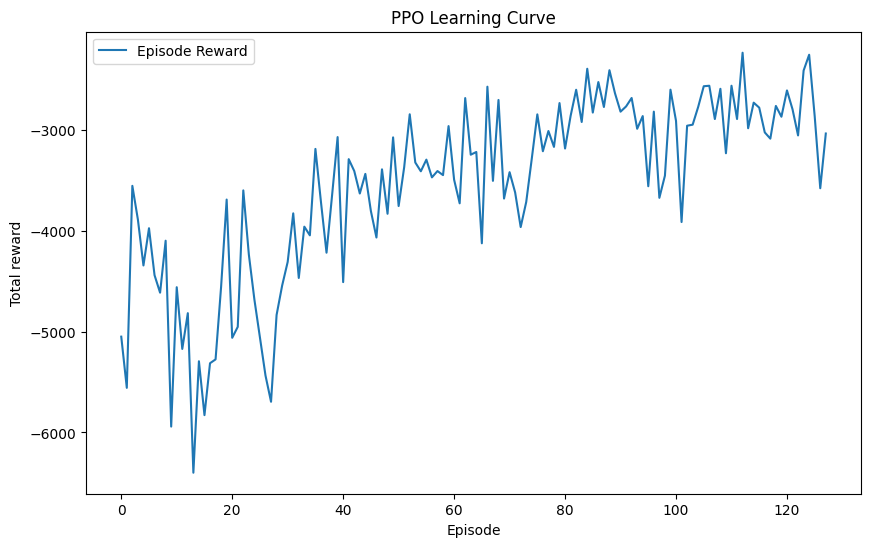

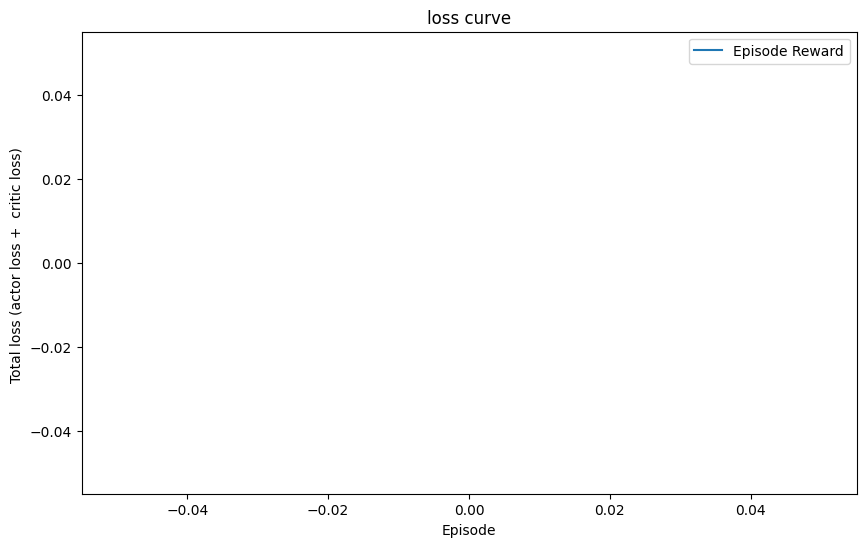

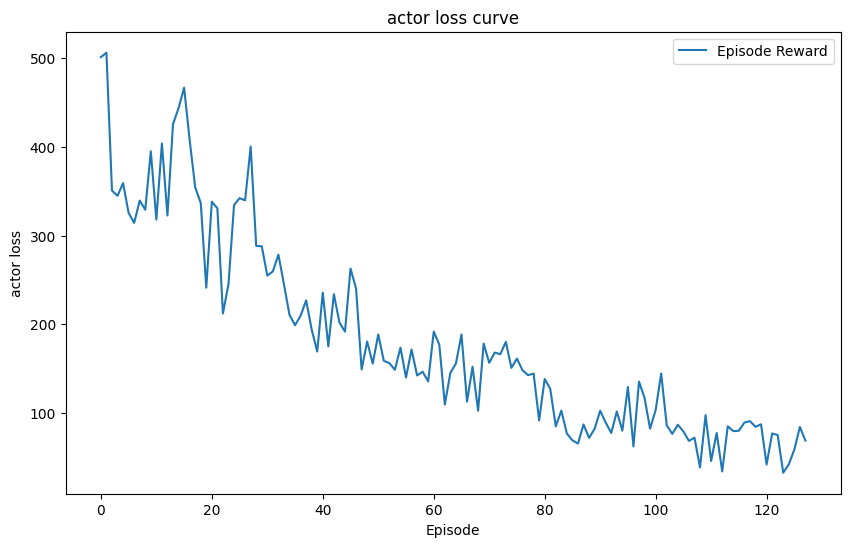

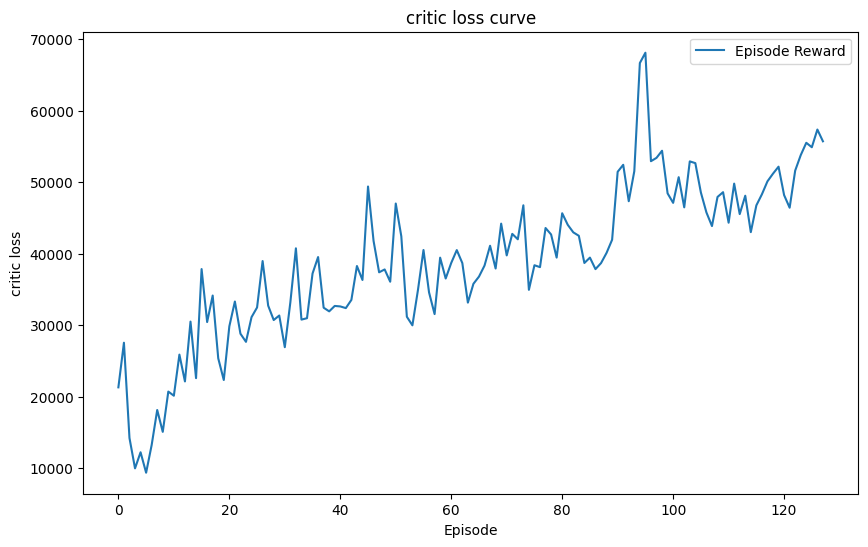

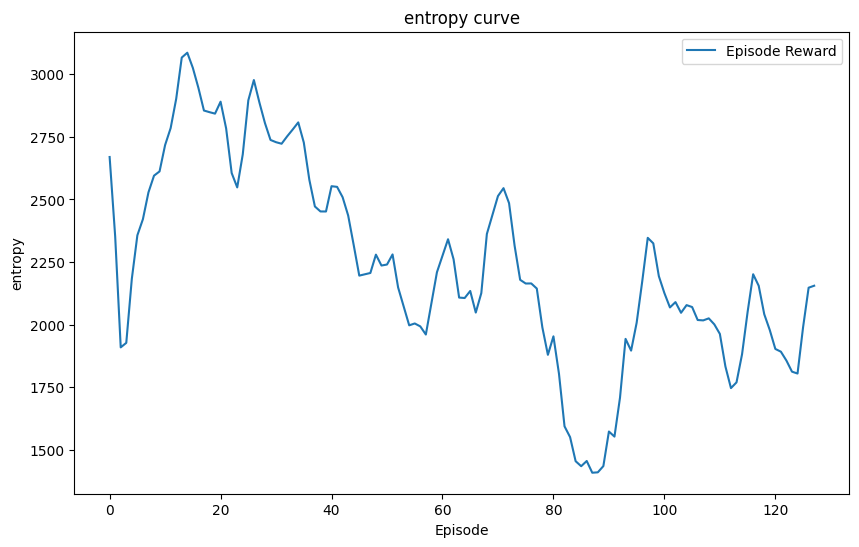

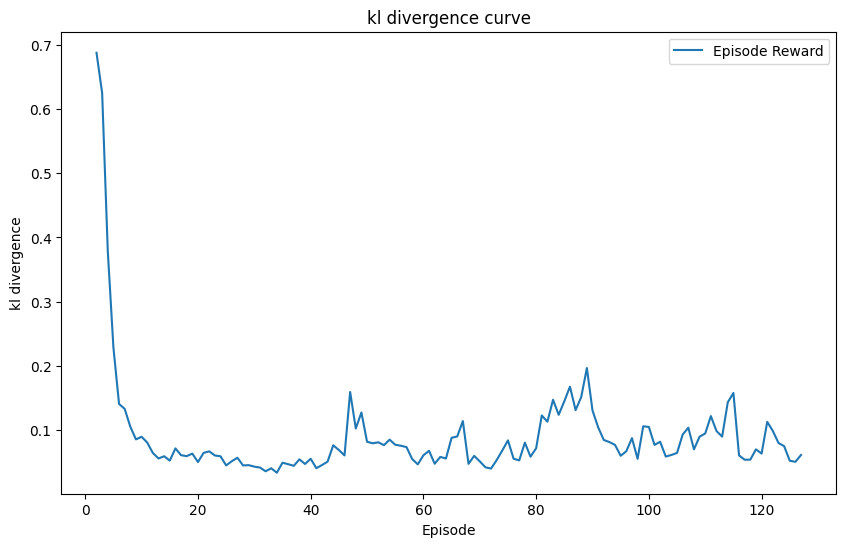

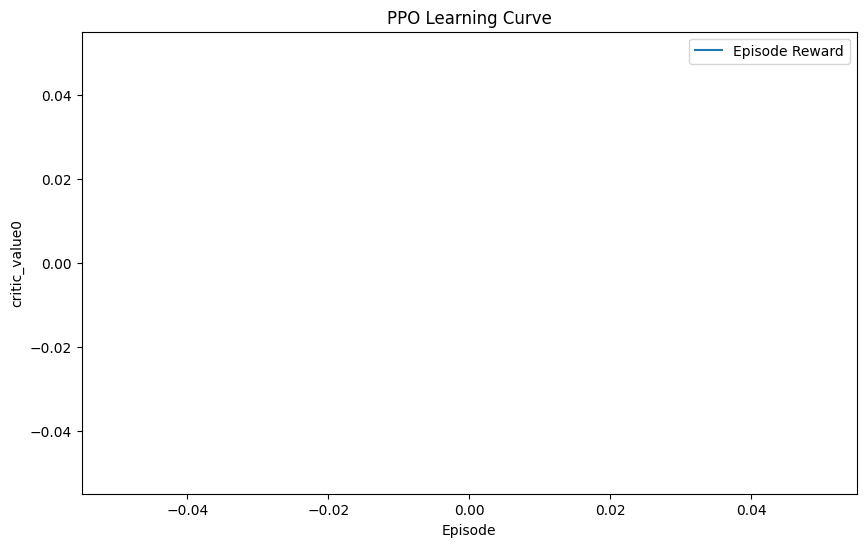

In [13]:
def plot_learning_curve(rewards, title="Learning Curve", label="Total reward"):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards, label='Episode Reward')

    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel(label)
    plt.legend()
    plt.show()

def plot_learning_curve2(rewards, title="Learning Curve", label="Total reward"):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards, label='Episode Reward')

    # 直近10エピソードの移動平均を計算してプロット
    if len(rewards) >= 10:
        moving_average = np.convolve(rewards, np.ones(10)/10, mode='valid')
        plt.plot(np.arange(9, len(rewards)), moving_average, label='Moving Average (last 10 episodes)', linestyle='--')

    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel(label)
    plt.legend()
    plt.show()


# エージェントの学習
# (agent.train()の呼び出しなど)

# 学習後のエージェントの評価
#evaluate_agent(agent, env, num_episodes=10)

# 学習曲線のプロット
last10=episode_reward_history[-10:]
print(last10)
print(np.mean(last10))
plot_learning_curve(episode_reward_history, title="PPO Learning Curve", label="Total reward")
plot_learning_curve(agent.loss_history_detail, title="loss curve", label="Total loss (actor loss +  critic loss) ")
plot_learning_curve(agent.actor_loss_history, title="actor loss curve", label="actor loss")
plot_learning_curve(agent.critic_loss_history, title="critic loss curve", label="critic loss")
plot_learning_curve(agent.entropy_history, title="entropy curve", label="entropy")
plot_learning_curve(agent.kl_divergence_history, title="kl divergence curve", label="kl divergence")
plot_learning_curve(critic_value0_history, title="PPO Learning Curve", label="critic_value0")


3 0.086761326
0.086761326 <class 'numpy.ndarray'>
3 0.060540278
0.060540278 <class 'numpy.ndarray'>
3 0.09609162
0.09609162 <class 'numpy.ndarray'>
3 0.049472336
0.049472336 <class 'numpy.ndarray'>
3 -0.003485535
-0.003485535 <class 'numpy.ndarray'>
3 -0.13562891
-0.13562891 <class 'numpy.ndarray'>
3 0.08550136
0.08550136 <class 'numpy.ndarray'>
3 -0.04833641
-0.04833641 <class 'numpy.ndarray'>
3 -0.03359742
-0.03359742 <class 'numpy.ndarray'>
3 0.10236853
0.10236853 <class 'numpy.ndarray'>
3 -0.01542266
-0.01542266 <class 'numpy.ndarray'>
3 -0.06442905
-0.06442905 <class 'numpy.ndarray'>
3 0.0956155
0.0956155 <class 'numpy.ndarray'>
3 0.1260075
0.1260075 <class 'numpy.ndarray'>
3 -0.09753311
-0.09753311 <class 'numpy.ndarray'>
3 -0.046444435
-0.046444435 <class 'numpy.ndarray'>
3 0.046043165
0.046043165 <class 'numpy.ndarray'>
3 -0.14864434
-0.14864434 <class 'numpy.ndarray'>
3 0.036011
0.036011 <class 'numpy.ndarray'>
3 -0.04158894
-0.04158894 <class 'numpy.ndarray'>
3 0.101470776
0.

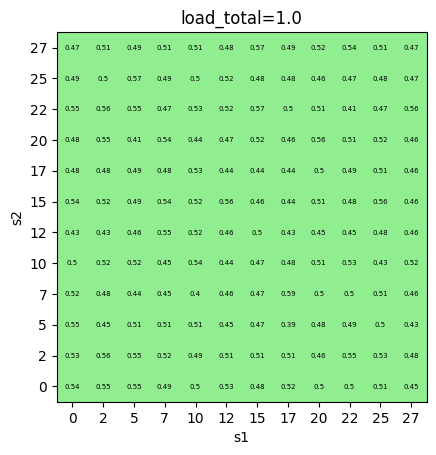

3 -0.030164992
-0.030164992 <class 'numpy.ndarray'>
3 0.087825455
0.087825455 <class 'numpy.ndarray'>
3 -0.1083189
-0.1083189 <class 'numpy.ndarray'>
3 0.044578727
0.044578727 <class 'numpy.ndarray'>
3 -0.17571655
-0.17571655 <class 'numpy.ndarray'>
3 -0.114995085
-0.114995085 <class 'numpy.ndarray'>
3 -0.13017644
-0.13017644 <class 'numpy.ndarray'>
3 0.098569065
0.098569065 <class 'numpy.ndarray'>
3 -0.2626932
-0.2626932 <class 'numpy.ndarray'>
3 -0.03468599
-0.03468599 <class 'numpy.ndarray'>
3 -0.08919115
-0.08919115 <class 'numpy.ndarray'>
3 -0.01035597
-0.01035597 <class 'numpy.ndarray'>
3 -0.014209517
-0.014209517 <class 'numpy.ndarray'>
3 0.04381218
0.04381218 <class 'numpy.ndarray'>
3 0.022395765
0.022395765 <class 'numpy.ndarray'>
3 0.0894711
0.0894711 <class 'numpy.ndarray'>
3 -0.014266674
-0.014266674 <class 'numpy.ndarray'>
3 0.06711065
0.06711065 <class 'numpy.ndarray'>
3 0.024281954
0.024281954 <class 'numpy.ndarray'>
3 -0.16719638
-0.16719638 <class 'numpy.ndarray'>
3 -0

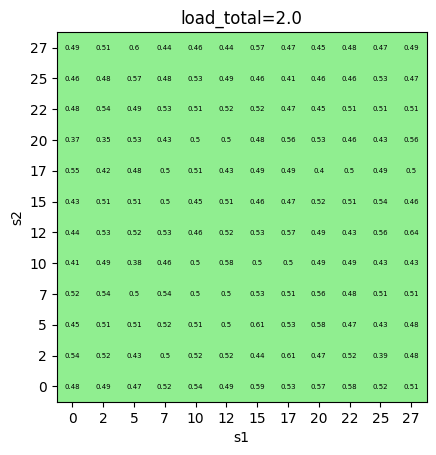

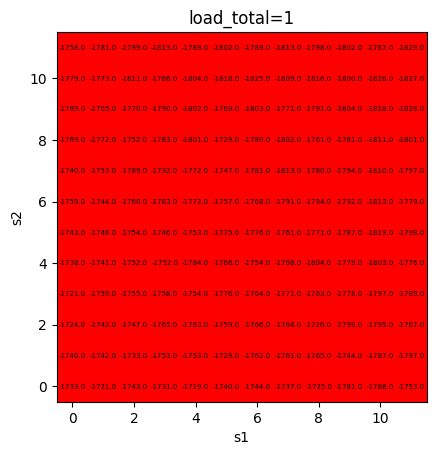

[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
[16305, 16463]


In [15]:
def one_hot_encoding(levels, n_units=2,n_states=5, MAX_maintenance_time=0):
    level_ohe = []
    #mstatus_ohe = []
    for unit_idx in range(n_units):
        l = [0] * n_states
        #m = [0] * (MAX_maintenance_time + 1)
        l[levels[unit_idx]] = 1
        #m[maintenance_status[unit_idx]] = 1
        level_ohe = level_ohe + l
        #mstatus_ohe = mstatus_ohe + m
    return level_ohe #, mstatus_ohe


def get_color(action):
    if action < 0:
        print(action)
        return "white"
    #cmap = ["red","sandybrown","orange","lawngreen","darkorange","lightgreen","green","lightblue"]
    cmap = ["red","orange","orange","lightgreen","orange","lightgreen","lightgreen","lightblue"]
    return cmap[action]

def plot_action(ax, center_x, center_y, act_dsc, act_cnt, load_total):
    size = 1
    opt_action = patches.Rectangle(
        (center_x-size/2, center_y-size/2),
        1,
        1,
        linewidth = 0,
        facecolor = get_color(act_dsc)
    )
    ax.add_patch(opt_action)
    #print(act_dsc)
    if act_dsc==0:
        ax.text(center_x,center_y,f'M12',ha='center', va='center')
    elif act_dsc==1:
        if center_x<center_y:
          ax.text(center_x,center_y,f'M2',ha='center', va='center')
        else:
          ax.text(center_x,center_y,f'M1',ha='center', va='center')
    elif act_dsc==2:
        if center_x<center_y:
          ax.text(center_x,center_y,f'M1',ha='center', va='center')
        else:
          ax.text(center_x,center_y,f'M2',ha='center', va='center')
    else: #稼働継続
        print(act_cnt, type(act_cnt))
        act_cnt = act_cnt * 0.5 + 0.5
        #ax.text(center_x, center_y,f'{(round(act_cnt[0],2),round(1-act_cnt[0],2))}',ha='center', va='center',fontsize=5)
        ax.text(center_x, center_y, f'{(round(act_cnt, 2))}', ha='center', va='center', fontsize=5)

def plot_state_value(ax, center_x, center_y, val):
    size = 1
    opt_action = patches.Rectangle(
        (center_x-size/2, center_y-size/2),
        1,
        1,
        linewidth = 0,
        facecolor = get_color(act_dsc)
    )
    ax.add_patch(opt_action)
    #print(act_dsc)

    ax.text(center_x, center_y, f'{round(float(val), 0)}', ha='center', va='center', fontsize=5)


def optimal_policy(load_total):
    fig, ax = plt.subplots()
    x = 10
    for s1 in range(x+2):
        for s2 in range(x+2):
            a =env.L/(x)
            x1 =s1*a
            x2 =s2*a

            flag1=0
            flag2=0
            if s1>=x:
              flag1=1
            if s2>=x:
              flag2=1

            #level_ohe = one_hot_encoding(levels=[s2,s3])
            state = [x1,x2] +[flag1,flag2] +list([load_total])
            #print(state)
            act_dsc, act_cnt, log_prob_dsc, log_prob_cnt, val = agent.choose_action_max_prob(state)
            act_dsc = act_dsc.item()
            act_cnt = act_cnt.squeeze().cpu().detach().numpy().copy()
            print(act_dsc,act_cnt)
            #print("val:",val)

            plot_action(ax, s1, s2, act_dsc, act_cnt, load_total)
    ax.set_xlim(-0.5,x+1.5)
    ax.set_ylim(-0.5,x+1.5)
    #cbar = plt.colorbar(scatter, cax=cax, ticks=np.arange(0.5, 8.5, 1))
    #cbar.ax.set_yticklabels([f'{i:b}' for i in range(8)])
    ax.set_aspect('equal', adjustable='box')  # アスペクト比を保持
    ax.set_xlabel("s1") #変更
    ax.set_ylabel("s2") #変更
    # グラフを表示
    ax.set_title("load_total="+str(load_total))

    # 軸のラベルを設定
    ax.set_xticks(range(x+2))  # 目盛りの位置を設定
    ax.set_xticklabels([f"{int(label * a)}" for label in ax.get_xticks()])  # X倍の値でラベルを整数で更新
    ax.set_yticks(range(x+2))
    ax.set_yticklabels([f"{int(label * a)}" for label in ax.get_yticks()])
    plt.show()

def state_value(load_total):
    fig, ax = plt.subplots()
    x = 10
    for s1 in range(x+2):
        for s2 in range(x+2):
            a =env.L/(x)
            x1 =s1*a
            x2 =s2*a

            flag1=0
            flag2=0
            if s1>=x:
              flag1=1
            if s2>=x:
              flag2=1

            #level_ohe = one_hot_encoding(levels=[s2,s3])
            state = [x1,x2] +[flag1,flag2] +list([load_total])
            act_dsc, act_cnt, log_prob_dsc, log_prob_cnt, val = agent.choose_action_max_prob(state)
            act_dsc = act_dsc.item()
            act_cnt = act_cnt.squeeze().cpu().detach().numpy().copy()
            #print(act_dsc,act_cnt)
            #print("val:",val)
            #status = np.array([(cs1<env.failures[0])*1,(cs2<env.failures[1])*1,(cs3<env.failures[2])*1])
            plot_state_value(ax, s1, s2, val)
    # 軸の範囲と目盛りを設定
    ax.set_xlim(-0.5,x+1.5)
    ax.set_ylim(-0.5,x+1.5)
    #cbar = plt.colorbar(scatter, cax=cax, ticks=np.arange(0.5, 8.5, 1))
    #cbar.ax.set_yticklabels([f'{i:b}' for i in range(8)])
    ax.set_aspect('equal', adjustable='box')  # アスペクト比を保持
    ax.set_xlabel("s1") #変更
    ax.set_ylabel("s2") #変更
    # グラフを表示
    ax.set_title("load_total="+str(load_total))


    plt.show()

#optimal_policy(load_total=0.2)
optimal_policy(load_total=1.0)
optimal_policy(load_total=2.0)


state_value(load_total=1)

#optimal_policy(s1=0,m1=0,m2=0,m3=0,b=1,d=0,t=1)
#optimal_policy(s1=1,m1=0,m2=0,m3=0,b=1,d=0,t=1)
#optimal_policy(s1=2,m1=0,m2=0,m3=0,b=1,d=0,t=1)
#optimal_policy(s1=3,m1=0,m2=0,m3=0,b=1,d=0,t=1)
#optimal_policy(s1=4,m1=0,m2=0,m3=0,b=1,d=0,t=1)
#optimal_policy(s1=4,m1=0,m2=0,m3=0,b=0,d=0,t=1)
#optimal_policy(s1=0,m1=1,m2=1,m3=0,b=1,d=0,t=1)
#optimal_policy(s1=0,m1=0,m2=0,m3=0,b=1,d=0,t=0.5)
#optimal_policy(s1=0,m1=0,m2=0,m3=0,b=-1,d=0,t=1)
#optimal_policy(s1=1,m1=0,m2=0,m3=0,b=-1,d=0,t=1)
#optimal_policy(s1=2,m1=0,m2=0,m3=0,b=-1,d=0,t=1)
#optimal_policy(s1=3,m1=0,m2=0,m3=0,b=-1,d=0,t=1)
#optimal_policy(s1=4,m1=0,m2=0,m3=0,b=-1,d=-1,t=0.3)
#optimal_policy(s1=0,m1=0,m2=0,m3=0,b=-1,d=-1,t=0.3)
#optimal_policy(s1=1,m1=0,m2=0,m3=0,b=-1,d=-1,t=0.3)
#optimal_policy(s1=2,m1=0,m2=0,m3=0,b=-1,d=-1,t=0.3)
#optimal_policy(s1=3,m1=0,m2=0,m3=0,b=-1,d=-1,t=0.3)
#optimal_policy(s1=4,m1=0,m2=0,m3=0,b=-1,d=-1,t=0.3)
s1 = 4
s2 = 4
s3 = 4
m1 = 0
m2 = 0
m3 = 0
inventory = 0
#demand = 0
remain_interval = 1
#level_ohe, mstatus_ohe = one_hot_encoding(levels=[s1,s2,s3],maintenance_status=[m1,m2,m3])
#state = level_ohe + mstatus_ohe + list([inventory,demand,remain_interval])
#act_dsc, act_cnt, log_prob, val = agent.choose_action_max_prob(state)
#act_dsc = act_dsc.item()
#act_dsc
print(env.Visit)
print(env.cntCount)

In [ ]:
"""
def get_color(action):
    if action < 0:
        return "white"
    #cmap = ["red","sandybrown","orange","lawngreen","darkorange","lightgreen","green","blue"]
    cmap = ["red","orange","orange","lightgreen","orange","lightgreen","lightgreen","lightblue"]
    return cmap[action]

def plot_action(ax, center_x, center_y, size, action):
    opt_action = patches.Rectangle(
        (center_x-size/2, center_y-size/2),
        size,
        size,
        linewidth = 0,
        facecolor = get_color(action)
    )
    ax.add_patch(opt_action)
    if action >= 0:
        r = list(map(int, bin(action)[2:].zfill(env.num_targets)))
        #ax.text(center_x,center_y,f'({r[0]},{r[1]},{r[2]})',ha='center', va='center')
        ax.text(center_x,center_y,f'{action}',ha='center', va='center')

def optimal_policy(load_total):
    fig, ax = plt.subplots()
    x = 26
    for s1 in range(x):
        for s2 in range(x):
            state = [s1,s2] + list([load_total])
            act_dsc, act_cnt, log_prob_dsc, log_prob_cnt, val = agent.choose_action_max_prob(state)
            act_dsc = act_dsc.item()
            act_cnt = act_cnt.squeeze().cpu().detach().numpy().copy()
            #print(act_dsc,act_cnt)
            print("val:",val)
            #status = np.array([(cs1<env.failures[0])*1,(cs2<env.failures[1])*1,(cs3<env.failures[2])*1])
            plot_action(ax, s1, s2, act_dsc, act_cnt, load_total)
            plot_action(ax,cs2,cs3,size=1,action=action)
    ax.set_xlim(-0.5,x-1+0.5)
    ax.set_ylim(-0.5,x-1+0.5)
    #cbar = plt.colorbar(scatter, cax=cax, ticks=np.arange(0.5, 8.5, 1))
    #cbar.ax.set_yticklabels([f'{i:b}' for i in range(8)])
    ax.set_aspect('equal', adjustable='box')  # アスペクト比を保持
    ax.set_xlabel("s2")
    ax.set_ylabel("s3")
    # グラフを表示
    ax.set_title("(s1="+str(cs1)+", s2, s3, z1="+str(cz1)+", z2="+str(cz2)+", z3="+str(cz3)+")")
    plt.show()

optimal_policy(load_total=0.2)
optimal_policy(load_total=1)
optimal_policy(load_total=1.8)
"""

In [ ]:
num_episode =1000#4で1分
threshold = 0 #cnt学習を開始するエピソード
best_reward = -np.inf
episode_reward_history2 = []
avg_cost = 0
critic_value0_history=[]
entropy_weight=0.01

for episode in range(num_episode):
    episode_reward = 0
    operation_time = 0
    one_action = 0
    two_action = 0
    three_action = 0
    penalty_action = 0
    #level_ohe, load_total = env.init_random()
    levels, flags, load_total = env.init_random()
    if episode % 100 == 0:
        interval_time_episode = time.time()
    interval_time_episode = time.time()
    for i in range(256):#1024*8
        #state = level_ohe + list([inventory,demand])
        #print(levels,"levels")
        state = levels + flags + list([load_total])
        #print(state)
        act_dsc, act_cnt, log_prob_dsc, log_prob_cnt, val = agent.choose_action_max_prob(state)#決定論的方策
        #act_dsc, act_cnt, log_prob_dsc, log_prob_cnt, val = agent.choose_action(state)#確率的方策
        log_prob=log_prob_dsc+log_prob_cnt
        act_dsc_list = [int(bit) for bit in format(act_dsc.item(), f'0{env.n_units}b')]
        if sum(act_dsc_list) == 2:
            one_action += 1
        elif sum(act_dsc_list) == 1:
            two_action += 1
        elif sum(act_dsc_list) == 0:
            three_action += 1
        act_cnt_np = act_cnt.squeeze().cpu().detach().numpy().copy()#決定論的方策
        #act_cnt_np = act_cnt.squeeze().cpu().numpy().copy()#確率的方策
        act_cnt_np = act_cnt_np * 0.5 + 0.5 #補正

        if act_cnt_np<0.5:
          env.cntCount[0]+=1
        else:
          env.cntCount[1]+=1
        #print(act_dsc_list,act_cnt_np)
        #reward, level_ohe_next, load_total_next= env.operation(act_dsc_list,act_cnt_np)
        reward, levels_next, flags_next, load_total_next= env.operation(act_dsc_list,act_cnt_np)

        episode_reward = episode_reward *0.99 + reward
        #episode_reward = episode_reward + reward *0.99
        #penalty_action += flag
        #if remain_interval > remain_interval_next:
            #operation_time += (remain_interval+1)/2*interval - (remain_interval_next+1)/2*interval
        #else:
            #operation_time += (remain_interval_next + 1) / 2 * interval        #agent.remember(state, act_dsc.item(), act_cnt.squeeze().cpu().numpy().copy(), log_prob_dsc, log_prob_cnt, val, reward, operation_time)
        #agent.remember(state, act_dsc.item(), act_cnt.squeeze().cpu().numpy().copy(), log_prob, val, reward)
        levels = levels_next
        flags = flags_next
        #mstatus_ohe = mstatus_ohe_next
        #inventory = inventory_next
        #demand = demand_next
        #remain_interval = remain_interval_next
        load_total = load_total_next
        if (i + 1) % 128 == 0:
           print("episode_reward,reward:",episode_reward,reward,"act_dsc, act_cnt:",act_dsc_list,act_cnt_np,"log_prob_dsc, log_prob_cnt, levels:",log_prob_dsc, log_prob_cnt, levels)
    #print(f'{episode}エピソード目の時間：{time.time()-interval_time_episode}')
    interval_time_episode = time.time()
    if threshold<=episode:
      entropy_weight =0.01


    #agent.learn(episode, entropy_weight)

    old_agent = Agent(n_units=n_units,
                        input_dims=input_size,
                        n_states=n_states,
                        MAX_maintenance_time=MAX_maintenance_time,
                        beta=beta,
                        interval=interval,
                        alpha_actor_d=alpha_actor_d,
                        alpha_actor_c=alpha_actor_c,
                        alpha_critic=alpha_critic,
                        policy_clip=policy_clip,
                        batch_size=batch_size,
                        n_epochs=n_epochs)
    if episode != 0:
        old_agent.load_models()

    #if Check_convergence(agent, old_agent, n_units, n_states, MAX_maintenance_time):
    #    break



    #agent.save_models()
    print(f'状態{state}, 離散行動：{act_dsc_list}, 連続行動：{act_cnt_np}')
    print(f'[保全を選択できた回数,1個故障で保全を選ばない回数, 2個故障で保全を選ばない回数, 3個故障で保全を選ばない回数] = [{env.replace_chance}, {env.failure_keep1}, {env.failure_keep2}, {env.failure_keep3}]')
    env.replace_chance = 0
    env.failure_keep1 = 0
    env.failure_keep2 = 0
    env.failure_keep3 = 0
    #print(f'{episode}エピソード目の学習時間：{time.time()-interval_time_episode}')
    episode_reward_history2.append(episode_reward)
    print(f'{episode}エピソード目の累積報酬：{episode_reward}, 一つ保全の回数：{one_action}, 二つ保全の回数：{two_action}, 三つ保全の回数：{three_action}, 違反回数：{penalty_action},episode_reward_history2：{episode_reward_history2}')

    critic_value0_history.append(float(agent.critic(state0)[0][0]))

In [ ]:
def plot_learning_curve(rewards, title="Learning Curve", label="Total reward"):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards, label='Episode Reward')

    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel(label)
    plt.legend()
    plt.show()

def plot_learning_curve2(rewards, title="Learning Curve", label="Total reward"):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards, label='Episode Reward')

    # 直近10エピソードの移動平均を計算してプロット
    if len(rewards) >= 10:
        moving_average = np.convolve(rewards, np.ones(10)/10, mode='valid')
        plt.plot(np.arange(9, len(rewards)), moving_average, label='Moving Average (last 10 episodes)', linestyle='--')

    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel(label)
    plt.legend()
    plt.show()

def plot_real_number_frequency(data):
    """
    実数の配列を受け取り、横軸に実数、縦軸にその実数が現れた回数をとるグラフを表示する関数。

    Parameters:
    data (list or np.array): 実数の配列

    Returns:
    None
    """
    plt.figure(figsize=(10, 6))
    # ヒストグラムをプロット
    plt.hist(data, bins=30, edgecolor='black')
    plt.xlabel('Real Numbers')
    plt.ylabel('Frequency')
    plt.title('Frequency of Real Numbers')
    plt.grid(True)
    plt.show()


# エージェントの学習
# (agent.train()の呼び出しなど)

# 学習後のエージェントの評価
#evaluate_agent(agent, env, num_episodes=10)

# 学習曲線のプロット
last100=episode_reward_history2[-100:]
print(last100)
print(np.mean(last100))
plot_real_number_frequency(episode_reward_history2)
plot_learning_curve(episode_reward_history2, title="PPO Learning Curve", label="Total reward")
plot_learning_curve(agent.loss_history_detail, title="loss curve", label="Total loss (actor loss +  critic loss) ")
plot_learning_curve(agent.actor_loss_history, title="actor loss curve", label="actor loss")
plot_learning_curve(agent.critic_loss_history, title="critic loss curve", label="critic loss")
plot_learning_curve(agent.entropy_history, title="entropy curve", label="entropy")
plot_learning_curve(agent.kl_divergence_history, title="kl divergence curve", label="kl divergence")
plot_learning_curve(critic_value0_history, title="PPO Learning Curve", label="critic_value0")


#df = pd.DataFrame(episode_reward_history, columns=['values'])
#df.to_csv('/content/reward1000.csv', index=False)
#np.save('/content/reward1000.npy', episode_reward_history)
np.save('/content/drive/MyDrive/result/reward1000-HAPPO.npy', episode_reward_history2)